In [16]:
import os
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
    os.chdir(Path(os.getcwd())/'..') # ew

import numpy as np
from tqdm.notebook import tqdm
import torch

# import minimax scaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
from response.maps import  collect_posterior_means
from deep_traffic_generation.cvae import CVAE
from deep_traffic_generation.core.datasets import TSDataset
from traffic.core import Traffic
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
# add automatic reloading of modules
%load_ext autoreload
%autoreload 2

device = "cpu"

# seed everything
np.random.seed(32)
torch.manual_seed(32)
torch.cuda.manual_seed(32)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading data and model

In [ ]:
# Load datasets and concatenate as specified
dataset = np.load(f'data/augmented_symbols.npy', allow_pickle=True)
dataset_removed = np.load(f'data/augmented_part_pruned.npy', allow_pickle=True)
dataset_kept = np.load(f'data/augmented_symbols_pruned.npy', allow_pickle=True)

In [3]:
# Concatenate the original with pruned and kept data
dataset_removed_combined = np.concatenate([dataset, dataset_removed], axis=0)
dataset_kept_combined = np.concatenate([dataset, dataset_kept], axis=0)

In [4]:
# Load labels and concatenate to match kept and removed data
labels = np.load(f'data/augmented_labels.npy', allow_pickle=True)
labels_pruned = np.load(f'data/augmented_labels_pruned.npy', allow_pickle=True)
labels_removed_combined = np.concatenate([labels, labels_pruned], axis=0)
labels_kept_combined = np.concatenate([labels, labels_pruned], axis=0)

100%|██████████| 2200/2200 [00:00<00:00, 5091.52it/s]


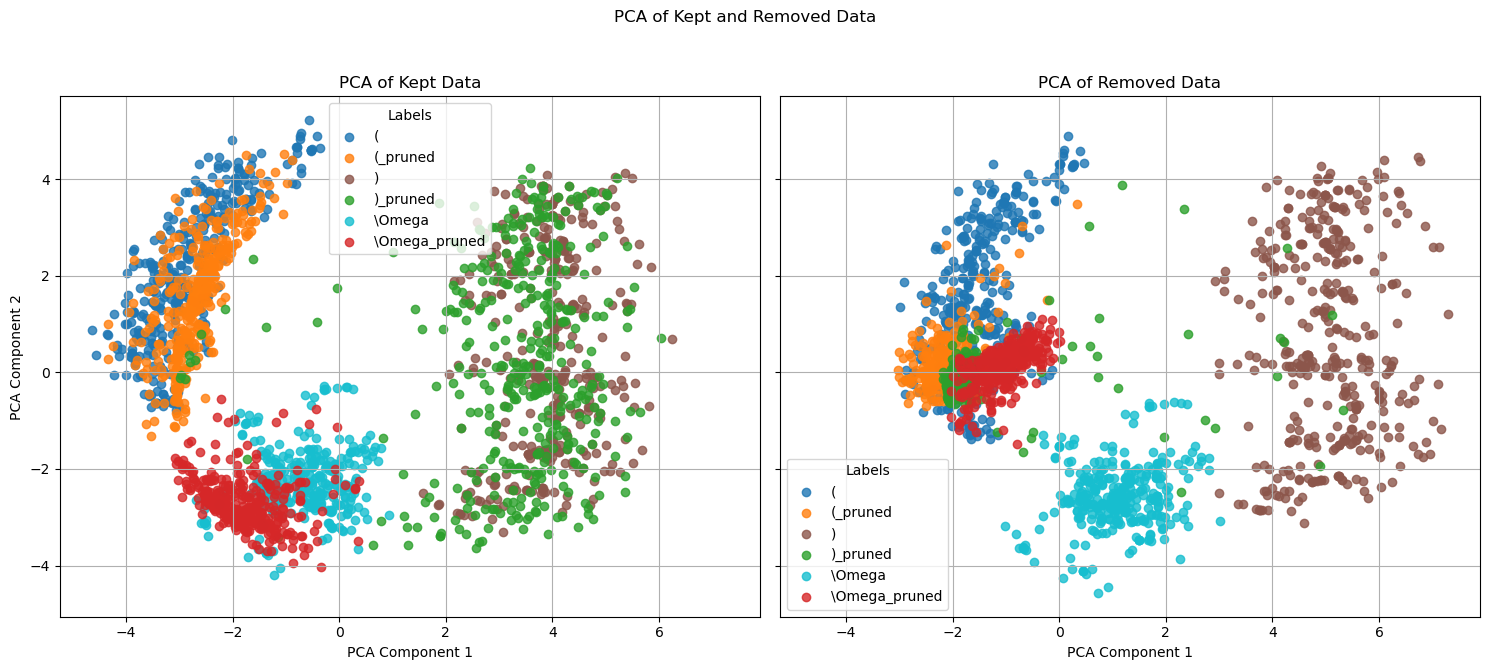

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Define function to collect posterior samples and perform PCA, returning the PCA results and labels
def calculate_pca_for_dataset(dataset_data, labels_data, batch_size, device):
    # Convert dataset into TSDataset format for model inference
    dataset_obj = TSDataset(np.swapaxes(dataset_data, 1, 2), None)

    path_tcvae = r"C:\Users\zakaria\Desktop\Work\MathWriting\augmented_symbols\CVAE_kld_5\epoch=989-step=1980.ckpt"
    model = CVAE.load_from_checkpoint(path_tcvae, map_location=device, dataset_params=dataset_obj.parameters).eval().to(device)
    
    # Collect posterior samples for the dataset
    Z = collect_posterior_means(model, dataset_obj, device=device, batch_size=batch_size, pbar=tqdm).detach().cpu()
    
    # Perform PCA on Z
    Z_pca = PCA(n_components=2).fit_transform(Z)
    
    return Z_pca, labels_data

# Get PCA data for kept and removed datasets
Z_pca_kept, labels_kept = calculate_pca_for_dataset(dataset_kept_combined, labels_kept_combined, 512, device)
Z_pca_removed, labels_removed = calculate_pca_for_dataset(dataset_removed_combined, labels_removed_combined, 512, device)

# Encode labels for consistent coloring
label_encoder = LabelEncoder()
encoded_labels_kept = label_encoder.fit_transform(labels_kept)
encoded_labels_removed = label_encoder.fit_transform(labels_removed)
unique_labels = np.unique(np.concatenate([labels_kept, labels_removed]))

# Define color dictionary to match the image colors
color_dict = {
    unique_labels[0]: '#1F77B4',  # Original blue color for 0
    unique_labels[1]: '#FF7F0E',  # Distinct orange color corresponding to 0
    unique_labels[2]: '#8C564B',  # Original brown color for 2
    unique_labels[3]: '#2CA02C',  # Distinct green color corresponding to 2
    unique_labels[4]: '#17BECF',  # Original teal color for 4
    unique_labels[5]: '#D62728'   # Distinct red color corresponding to 4
}

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)

# Plot PCA for kept data
axes[0].set_title("PCA of Kept Data")
for label in unique_labels:
    idx_kept = np.where(labels_kept == label)
    axes[0].scatter(Z_pca_kept[idx_kept, 0], Z_pca_kept[idx_kept, 1], color=color_dict[label], label=label, alpha=0.8)
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(title="Labels")
axes[0].grid(True)  # Add grid to the first subplot

# Plot PCA for removed data
axes[1].set_title("PCA of Removed Data")
for label in unique_labels:
    idx_removed = np.where(labels_removed == label)
    axes[1].scatter(Z_pca_removed[idx_removed, 0], Z_pca_removed[idx_removed, 1], color=color_dict[label], label=label, alpha=0.8)
axes[1].set_xlabel("PCA Component 1")
axes[1].legend(title="Labels")
axes[1].grid(True)  # Add grid to the second subplot

# Display the combined figure
plt.suptitle("PCA of Kept and Removed Data")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()
